# DKRZ Python visualization


## Derotate curvilinear grid with rotated_pole

----

```
Copyright 2022 Deutsches Klimarechenzentrum GmbH (DKRZ)
Licensed under CC-BY-NC-SA-4.0
```

----

A curvilinear grid has 2-dimensional coordinate variables `lon(y,x)` and `lat(y,x)`. 

Some models work with curvilinear grids with a rotated pole, like CORDEX or REMO. In this case the coordinate variables are named `rlon(x)` and `rlat(y)` and an additional variable named rotated_pole is added to the file.


For plotting you can use Cartopy's crs.RotatedPole projection for the transformation 


About:
    REMO-RCM:                  https://www.remo-rcm.de/059966/index.php.en
    CORDEX domain description: https://cordex.org/domains/cordex-domain-description/

**Content:**
1. Function to read the variable data, coordinates and rotated pole coordinate
1. Function to derotate the rlon coordinate data
1. Function to unrotate the rlat coordinate data
1. Read file content and return relevant variables
1. Plot rotated data

<br>

In [1]:
import sys, os

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Function to read the variable data, coordinates and rotated pole coordinate

In [2]:
def read_data(file_name, varname):
    """
    Read netcdf file and return arrays: lat, lon, var, rotated pole lon and lat
    """
    ds = xr.open_dataset(file_name)
    print(ds[varname].shape)
    var  = ds[varname]
    rlat = ds.rlat
    rlon = ds.rlon
    pole = ds.rotated_pole

    try:
        if hasattr(pole,'grid_north_pole_longitude'):
            px = pole.attrs['grid_north_pole_longitude']
        if hasattr(pole,'grid_north_pole_latitude'):
            py = pole.attrs['grid_north_pole_latitude']
    except:
        print('Unexpected error:', sys.exc_info()[0])
        raise

    return rlon, rlat, var, px, py

## Function to derotate the rlon coordinate data

In [3]:
def unrot_lon(rlat, rlon, pole_lat, pole_lon):
    """
    Transform rotated longitude to regular non-rotated longitude lon(2D).
    """
    nrlat = np.shape(rlat)
    nrlon = np.shape(rlon)

    nrlat_rank = np.ndim(nrlat)
    nrlon_rank = np.ndim(nrlon)

    if(np.any(nrlat != nrlon) and (nrlat_rank != 1 or nrlon_rank != 1)):
        print("Function unrot_lon: rlat and rlon dimensions do not match")
        exit()

    if(nrlat_rank == 1 and nrlon_rank == 1):
        rlo = np.tile(rlon, (nrlat[0],1))
        rla = np.transpose([rlat]*nrlon[0])
    else:
        rla = rlat
        rlo = rlon

    rla = np.deg2rad(rla)
    rlo = np.deg2rad(rlo)

    s1 = np.sin(np.deg2rad(pole_lat))
    c1 = np.cos(np.deg2rad(pole_lat))
    s2 = np.sin(np.deg2rad(pole_lon))
    c2 = np.cos(np.deg2rad(pole_lon))

    tmp1 = s2*(-s1*np.cos(rlo)*np.cos(rla)+c1*np.sin(rla))-c2*np.sin(rlo)*np.cos(rla)
    tmp2 = c2*(-s1*np.cos(rlo)*np.cos(rla)+c1*np.sin(rla))+s2*np.sin(rlo)*np.cos(rla)

    lon = np.rad2deg(np.arctan(tmp1/tmp2))

    print('Function unrot_lon: min/max  %f / %f' % (np.min(lon[0,:]), np.max(lon[0,:])) )

    return lon

## Function to unrotate the rlat coordinate data

In [4]:
def unrot_lat(rlat, rlon, pole_lat, pole_lon):
    """
    Transform rotated latitude to regular non-rotated latitude lat(2D)
    """
    nrlat = np.shape(rlat)
    nrlon = np.shape(rlon)

    nrlat_rank = np.ndim(nrlat)
    nrlon_rank = np.ndim(nrlon)

    if(np.any(nrlat != nrlon) and (nrlat_rank != 1 or nrlon_rank != 1)):
        print("Function unrot_lat: rlat and rlon dimensions do not match")
        exit()

    if(nrlat_rank == 1 and nrlon_rank == 1):
        rlo = np.tile(rlon, (nrlat[0],1))
        rla = np.transpose([rlat]*nrlon[0])
    else:
        rla = rlat
        rlo = rlon

    rla = np.deg2rad(rla)
    rlo = np.deg2rad(rlo)

    s1 = np.sin(np.deg2rad(pole_lat))
    c1 = np.cos(np.deg2rad(pole_lat))

    lat = s1*np.sin(rla)+c1*np.cos(rla)*np.cos(rlo)
    lat = np.rad2deg(np.arcsin(lat))

    print('Function unrot_lat: min/max  %f / %f' % (np.min(lat[0,:]), np.max(lat[0,:])) )

    return lat

## Read file content and return relevant variables

File path and name

In [6]:
fname = '../../data/COSMO_REA6_CONST_withOUTsponge.nc'

varname = 'HSURF'

rlon, rlat, var, pole_lon, pole_lat = read_data(fname, 'HSURF')

## Plot rotated data

The rotated data lays over the western part of Africa but it should be over Europe when derotated to its origin.

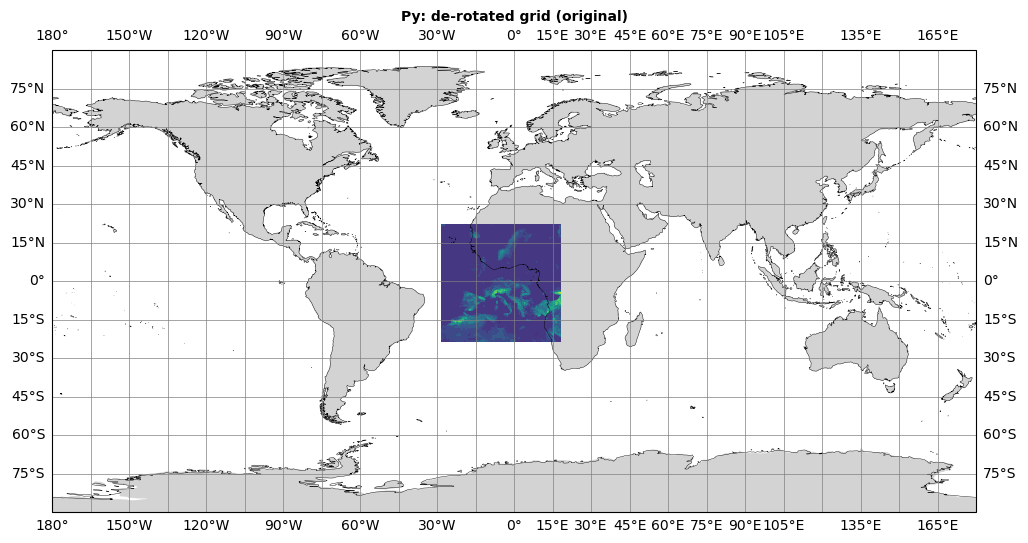

In [7]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw={"projection":ccrs.PlateCarree()})

ax.set_global()
ax.add_feature(cfeature.OCEAN, color='white', zorder=0)
ax.add_feature(cfeature.LAND, color='lightgray',zorder=0,
               linewidth=0.5, edgecolor='black')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', xlocs=range(-180,180,15), ylocs=range(-90,90,15))
ax.coastlines(resolution='50m', linewidth=0.3, color='black')
ax.set_title('Py: de-rotated grid (original)', fontsize=10, fontweight='bold')

crs = ccrs.PlateCarree()
ax.contourf(rlon,rlat, var, levels=15, transform=crs)

#plt.savefig('./plots/plot_Python_curvilinear_grid_rotated.png', bbox_inches='tight', dpi=100)

## Unrotate the rlon, rlat, data 

In [8]:
lon = unrot_lon(rlat, rlon, pole_lat, pole_lon)
lat = unrot_lat(rlat, rlon, pole_lat, pole_lon)

Function unrot_lon: min/max  -10.077327 / 36.432936
Function unrot_lat: min/max  21.951927 / 27.346996


## Plot derotated data

1. Use the rlon/rlat coordinates with transformation projection crs.RotatedPole()
2. Use the derotated coordinate variables lon and lat

**1. Use the rlon/rlat coordinates with transformation projection crs.RotatedPole()**


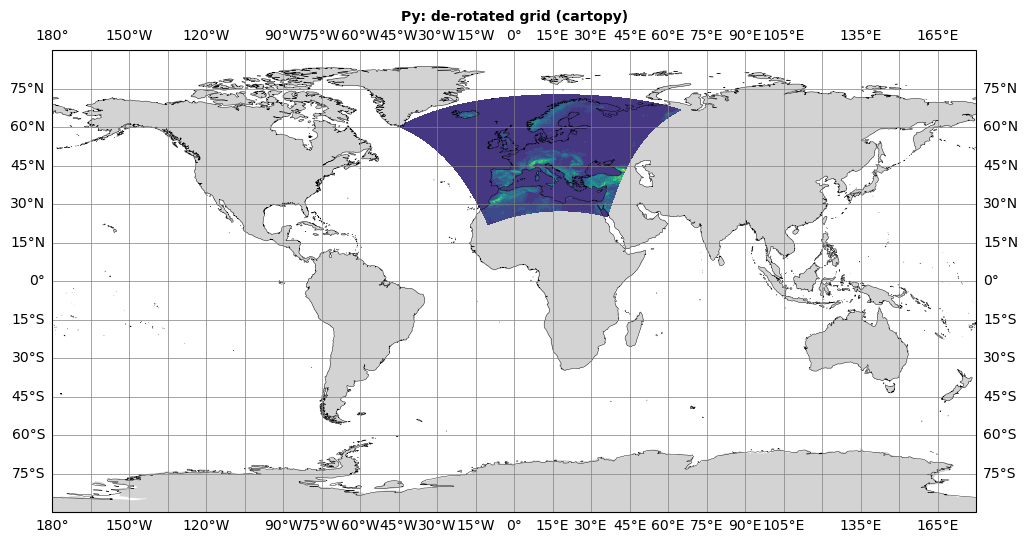

In [9]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw={"projection":ccrs.PlateCarree()})

ax.set_global()
#ax.set_extent([-46, 70, 20, 75], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, color='white', zorder=0)
ax.add_feature(cfeature.LAND, color='lightgray',zorder=0,
               linewidth=0.5, edgecolor='black')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', xlocs=range(-180,180,15), ylocs=range(-90,90,15))
ax.coastlines(resolution='50m', linewidth=0.3, color='black')
ax.set_title('Py: de-rotated grid (cartopy)', fontsize=10, fontweight='bold')

crs = ccrs.RotatedPole(pole_longitude=pole_lon, pole_latitude=pole_lat)
ax.contourf(rlon, rlat, var, levels=15, transform=crs)

plt.savefig('./plots/plot_Python_curvilinear_grid_derotated_1.png', bbox_inches='tight', dpi=200)

**2. Use the derotated coordinate variables lon and lat**


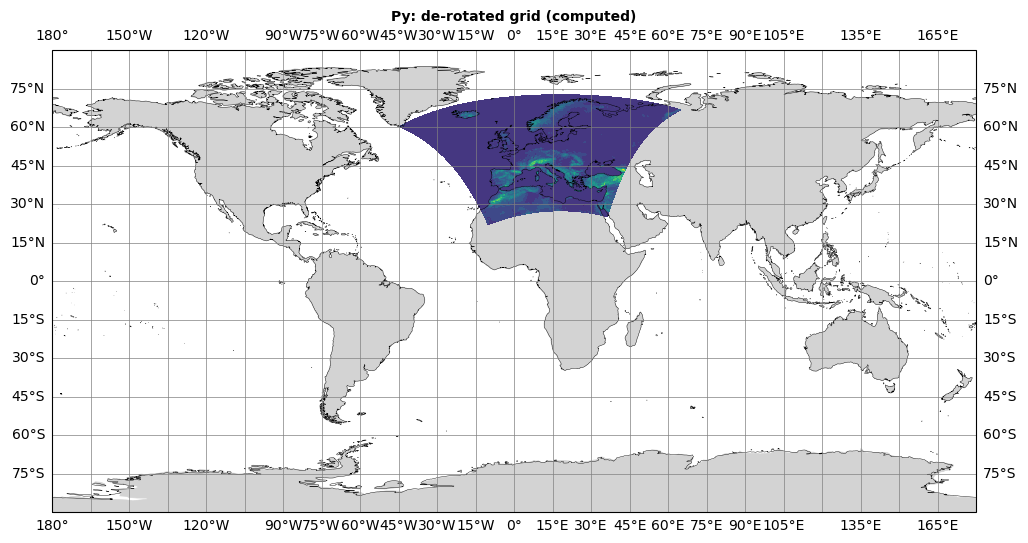

In [10]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw={"projection":ccrs.PlateCarree()})

ax.set_global()
#ax.set_extent([-46, 70, 20, 75], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, color='white', zorder=0)
ax.add_feature(cfeature.LAND, color='lightgray',zorder=0,
               linewidth=0.5, edgecolor='black')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', xlocs=range(-180,180,15), ylocs=range(-90,90,15))
ax.coastlines(resolution='50m', linewidth=0.3, color='black')
ax.set_title('Py: de-rotated grid (computed)', fontsize=10, fontweight='bold')

crs = ccrs.PlateCarree()
ax.contourf(lon, lat, var, levels=15, transform=crs)

plt.savefig('./plots/plot_Python_curvilinear_grid_derotated_2.png', bbox_inches='tight', dpi=200)